In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode
%matplotlib inline

In [2]:
# covertes to tensor and normalizes the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_set = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform
)

# load the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


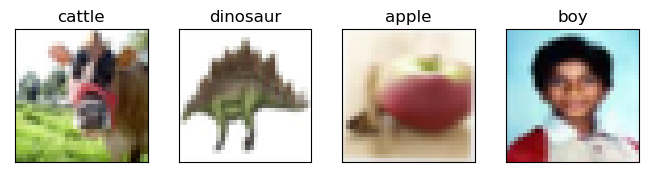

In [3]:
# to see how our augmented data looks like
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
images, labels = next(iter(sample_loader))  # obtain one batch of augmented data 
images = images.numpy()

# plot the images in the batch, along with corresponding labels
fig = plt.figure(figsize=(25, 10))
for i in np.arange(4):
    ax = fig.add_subplot(5, 12, i+1, xticks=[], yticks=[])
    img = np.squeeze(np.transpose(images[i], (1,2,0)))  # B*C*H*W --> H*W*C
    img = img/2 + 0.5  # un-normalize the image
    ax.imshow(img)
    ax.set_title(train_set.classes[labels[i].item()])

plt.show()

In [4]:
len(train_set),len(test_set),len(train_set.classes)

(50000, 10000, 100)

In [5]:
train_classes_items = dict()

for train_item in train_set:
    label = train_set.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [6]:
test_classes_items = dict()
for test_item in test_set:
    label = test_set.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

In [5]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_set.classes))

##### 1(a)
From above, we know that

1. The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes.
2. There are 500 training images and 100 testing images per class.

I also adjust the output of FC layer to be the number of classes in the traing set.

##### 1(b)


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
#     acc = {}
#     loss = {}

    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                print("last_lr:",scheduler.get_last_lr()[0])
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            

            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)


In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=225)

Epoch 0/224
----------
last_lr: 0.001
train Loss: 2.8716 Acc: 0.3071
val Loss: 1.9399 Acc: 0.4813

Epoch 1/224
----------
last_lr: 0.001
train Loss: 1.6848 Acc: 0.5329
val Loss: 1.6402 Acc: 0.5447

Epoch 2/224
----------
last_lr: 0.001
train Loss: 1.2476 Acc: 0.6443
val Loss: 1.5887 Acc: 0.5660

Epoch 3/224
----------
last_lr: 0.001
train Loss: 0.9358 Acc: 0.7254
val Loss: 1.5676 Acc: 0.5804

Epoch 4/224
----------
last_lr: 0.001
train Loss: 0.7052 Acc: 0.7903
val Loss: 1.5998 Acc: 0.5887

Epoch 5/224
----------
last_lr: 0.001
train Loss: 0.5289 Acc: 0.8403
val Loss: 1.6555 Acc: 0.5957

Epoch 6/224
----------
last_lr: 0.001
train Loss: 0.4065 Acc: 0.8790
val Loss: 1.7176 Acc: 0.5910

Epoch 7/224
----------
last_lr: 0.001
train Loss: 0.2915 Acc: 0.9132
val Loss: 1.7949 Acc: 0.5945

Epoch 8/224
----------
last_lr: 0.001
train Loss: 0.2378 Acc: 0.9280
val Loss: 1.8334 Acc: 0.5948

Epoch 9/224
----------
last_lr: 0.001
train Loss: 0.1914 Acc: 0.9416
val Loss: 1.8958 Acc: 0.5971

Epoch 10/2

##### The accuracy rate using the finetuning  approach discussed in 1(b) is .6336.

In [17]:
model_new_1 = models.resnet50(pretrained=True)
num_ftrs_new_1 = model_new_1.fc.in_features
model_new_1.fc = nn.Linear(num_ftrs_new_1, len(train_set.classes))

BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_new_1 = model_new_1.to(device)
criterion = nn.CrossEntropyLoss()


optimizer_ft_new_1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_1 = lr_scheduler.StepLR(optimizer_ft_new_1, step_size=60, gamma=0.1)
model_new_1 = train_model(model_new_1, criterion, optimizer_ft_new_1, exp_lr_scheduler_1,num_epochs=225)

Epoch 0/224
----------
last_lr: 0.01
train Loss: 4.7196 Acc: 0.0089
val Loss: 4.7872 Acc: 0.0084

Epoch 1/224
----------
last_lr: 0.01
train Loss: 4.7188 Acc: 0.0087
val Loss: 4.7698 Acc: 0.0089

Epoch 2/224
----------
last_lr: 0.01
train Loss: 4.7176 Acc: 0.0099
val Loss: 4.7580 Acc: 0.0094

Epoch 3/224
----------
last_lr: 0.01
train Loss: 4.7214 Acc: 0.0093
val Loss: 4.7631 Acc: 0.0080

Epoch 4/224
----------
last_lr: 0.01
train Loss: 4.7191 Acc: 0.0095
val Loss: 4.7550 Acc: 0.0089

Epoch 5/224
----------
last_lr: 0.01
train Loss: 4.7195 Acc: 0.0094
val Loss: 4.7662 Acc: 0.0090

Epoch 6/224
----------
last_lr: 0.01
train Loss: 4.7184 Acc: 0.0092
val Loss: 4.7579 Acc: 0.0085

Epoch 7/224
----------
last_lr: 0.01
train Loss: 4.7196 Acc: 0.0096
val Loss: 4.7897 Acc: 0.0092

Epoch 8/224
----------
last_lr: 0.01
train Loss: 4.7202 Acc: 0.0093
val Loss: 4.7773 Acc: 0.0087

Epoch 9/224
----------
last_lr: 0.01
train Loss: 4.7203 Acc: 0.0091
val Loss: 4.7872 Acc: 0.0084

Epoch 10/224
-------

In [18]:
model_new_2 = models.resnet50(pretrained=True)
num_ftrs_new_2 = model_new_2.fc.in_features
model_new_2.fc = nn.Linear(num_ftrs_new_2, len(train_set.classes))

BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_new_2 = model_new_2.to(device)
criterion = nn.CrossEntropyLoss()


optimizer_ft_new_2 = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler_2 = lr_scheduler.StepLR(optimizer_ft_new_2, step_size=60, gamma=0.1)
model_new_2 = train_model(model_new_2, criterion, optimizer_ft_new_2, exp_lr_scheduler_2,num_epochs=225)

Epoch 0/224
----------
last_lr: 0.1
train Loss: 4.7135 Acc: 0.0095
val Loss: 4.7610 Acc: 0.0094

Epoch 1/224
----------
last_lr: 0.1
train Loss: 4.7129 Acc: 0.0097
val Loss: 4.7611 Acc: 0.0092

Epoch 2/224
----------
last_lr: 0.1
train Loss: 4.7120 Acc: 0.0099
val Loss: 4.7640 Acc: 0.0086

Epoch 3/224
----------
last_lr: 0.1
train Loss: 4.7137 Acc: 0.0100
val Loss: 4.7885 Acc: 0.0086

Epoch 4/224
----------
last_lr: 0.1
train Loss: 4.7117 Acc: 0.0088
val Loss: 4.7524 Acc: 0.0087

Epoch 5/224
----------
last_lr: 0.1
train Loss: 4.7121 Acc: 0.0096
val Loss: 4.7852 Acc: 0.0093

Epoch 6/224
----------
last_lr: 0.1
train Loss: 4.7133 Acc: 0.0098
val Loss: 4.7784 Acc: 0.0100

Epoch 7/224
----------
last_lr: 0.1
train Loss: 4.7125 Acc: 0.0093
val Loss: 4.7984 Acc: 0.0084

Epoch 8/224
----------
last_lr: 0.1
train Loss: 4.7136 Acc: 0.0094
val Loss: 4.7636 Acc: 0.0084

Epoch 9/224
----------
last_lr: 0.1
train Loss: 4.7138 Acc: 0.0095
val Loss: 4.7463 Acc: 0.0087

Epoch 10/224
----------
last_l



In 1(c) I repeated the same simulation using two higher learning rates (0.01,0.1). It's not surprised that the accuracy for these models are much worse than 1(b) primailiry becuase of the mechanism of pretraining, we want to start with a much smaller learning rate (0.001) with decaying to fully take advantage of the pretained model, and thus 0.001 is ideal and gives the best accuracy.

### 1.2(a)

In [19]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs_conv = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs_conv, len(train_set.classes))


BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,num_epochs=225)


Epoch 0/224
----------
last_lr: 0.001
train Loss: 3.9920 Acc: 0.1450
val Loss: 3.5570 Acc: 0.2259

Epoch 1/224
----------
last_lr: 0.001
train Loss: 3.3904 Acc: 0.2426
val Loss: 3.3017 Acc: 0.2545

Epoch 2/224
----------
last_lr: 0.001
train Loss: 3.1792 Acc: 0.2702
val Loss: 3.1661 Acc: 0.2778

Epoch 3/224
----------
last_lr: 0.001
train Loss: 3.0656 Acc: 0.2867
val Loss: 3.1060 Acc: 0.2879

Epoch 4/224
----------
last_lr: 0.001
train Loss: 2.9887 Acc: 0.2975
val Loss: 3.0727 Acc: 0.2868

Epoch 5/224
----------
last_lr: 0.001
train Loss: 2.9205 Acc: 0.3065
val Loss: 3.0300 Acc: 0.2963

Epoch 6/224
----------
last_lr: 0.001
train Loss: 2.8811 Acc: 0.3161
val Loss: 2.9977 Acc: 0.2995

Epoch 7/224
----------
last_lr: 0.001
train Loss: 2.8436 Acc: 0.3213
val Loss: 3.0075 Acc: 0.3021

Epoch 8/224
----------
last_lr: 0.001
train Loss: 2.8015 Acc: 0.3282
val Loss: 2.9793 Acc: 0.3013

Epoch 9/224
----------
last_lr: 0.001
train Loss: 2.7728 Acc: 0.3312
val Loss: 2.9613 Acc: 0.3082

Epoch 10/2

In [20]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs_conv = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs_conv, len(train_set.classes))


BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,num_epochs=225)


Epoch 0/224
----------
last_lr: 0.01
train Loss: 3.5405 Acc: 0.2094
val Loss: 3.4599 Acc: 0.2514

Epoch 1/224
----------
last_lr: 0.01
train Loss: 3.1467 Acc: 0.2751
val Loss: 3.1473 Acc: 0.2852

Epoch 2/224
----------
last_lr: 0.01
train Loss: 2.9843 Acc: 0.3008
val Loss: 3.2290 Acc: 0.2945

Epoch 3/224
----------
last_lr: 0.01
train Loss: 2.8967 Acc: 0.3156
val Loss: 3.2943 Acc: 0.2949

Epoch 4/224
----------
last_lr: 0.01
train Loss: 2.8321 Acc: 0.3272
val Loss: 3.1591 Acc: 0.2951

Epoch 5/224
----------
last_lr: 0.01
train Loss: 2.7682 Acc: 0.3383
val Loss: 3.1864 Acc: 0.2958

Epoch 6/224
----------
last_lr: 0.01
train Loss: 2.7192 Acc: 0.3484
val Loss: 3.2250 Acc: 0.2995

Epoch 7/224
----------
last_lr: 0.01
train Loss: 2.6685 Acc: 0.3566
val Loss: 3.1909 Acc: 0.3084

Epoch 8/224
----------
last_lr: 0.01
train Loss: 2.6626 Acc: 0.3571
val Loss: 3.2074 Acc: 0.3001

Epoch 9/224
----------
last_lr: 0.01
train Loss: 2.6267 Acc: 0.3661
val Loss: 3.2118 Acc: 0.3108

Epoch 10/224
-------

In [21]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs_conv = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs_conv, len(train_set.classes))


BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,num_epochs=225)


Epoch 0/224
----------
last_lr: 0.1
train Loss: 12.3082 Acc: 0.1517
val Loss: 14.1448 Acc: 0.1885

Epoch 1/224
----------
last_lr: 0.1
train Loss: 13.0228 Acc: 0.2036
val Loss: 15.2002 Acc: 0.1979

Epoch 2/224
----------
last_lr: 0.1
train Loss: 12.9178 Acc: 0.2224
val Loss: 15.1947 Acc: 0.2160

Epoch 3/224
----------
last_lr: 0.1
train Loss: 12.7187 Acc: 0.2394
val Loss: 14.1767 Acc: 0.2260

Epoch 4/224
----------
last_lr: 0.1
train Loss: 12.6361 Acc: 0.2487
val Loss: 16.8195 Acc: 0.2054

Epoch 5/224
----------
last_lr: 0.1
train Loss: 12.6188 Acc: 0.2550
val Loss: 16.4038 Acc: 0.2277

Epoch 6/224
----------
last_lr: 0.1
train Loss: 12.4846 Acc: 0.2646
val Loss: 16.8153 Acc: 0.2273

Epoch 7/224
----------
last_lr: 0.1
train Loss: 12.5331 Acc: 0.2716
val Loss: 18.3216 Acc: 0.2152

Epoch 8/224
----------
last_lr: 0.1
train Loss: 12.3980 Acc: 0.2788
val Loss: 15.9363 Acc: 0.2382

Epoch 9/224
----------
last_lr: 0.1
train Loss: 12.3806 Acc: 0.2836
val Loss: 16.4437 Acc: 0.2345

Epoch 10/2

In [22]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs_conv = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs_conv, len(train_set.classes))


BATCH_SIZE=64

train_dl = DataLoader(train_set,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_set,BATCH_SIZE,num_workers=4,pin_memory=True)

dataloaders = {'train':train_dl,'val':test_dl}
dataset_sizes = {'train':len(train_set),'val':len(test_set)}

class_names = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=1, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=60, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,num_epochs=225)

Epoch 0/224
----------
last_lr: 1
train Loss: 143.3151 Acc: 0.1482
val Loss: 163.9043 Acc: 0.1753

Epoch 1/224
----------
last_lr: 1
train Loss: 140.8206 Acc: 0.1964
val Loss: 166.3504 Acc: 0.2026

Epoch 2/224
----------
last_lr: 1
train Loss: 137.8703 Acc: 0.2191
val Loss: 161.9697 Acc: 0.2069

Epoch 3/224
----------
last_lr: 1
train Loss: 136.3465 Acc: 0.2339
val Loss: 171.7886 Acc: 0.2251

Epoch 4/224
----------
last_lr: 1
train Loss: 137.2922 Acc: 0.2443
val Loss: 162.2311 Acc: 0.2139

Epoch 5/224
----------
last_lr: 1
train Loss: 134.1134 Acc: 0.2515
val Loss: 171.4410 Acc: 0.2232

Epoch 6/224
----------
last_lr: 1
train Loss: 133.3461 Acc: 0.2597
val Loss: 175.0466 Acc: 0.2300

Epoch 7/224
----------
last_lr: 1
train Loss: 134.1276 Acc: 0.2658
val Loss: 171.6630 Acc: 0.2230

Epoch 8/224
----------
last_lr: 1
train Loss: 134.4520 Acc: 0.2687
val Loss: 178.7032 Acc: 0.2275

Epoch 9/224
----------
last_lr: 1
train Loss: 133.8771 Acc: 0.2770
val Loss: 165.8235 Acc: 0.2405

Epoch 10/2

2(a) the learning rate of 0.001 provides the best accuracy(0.348) relative to others.

2(b) The fineturning apporoach with a learning rate of 0.001 provides the best accuracy for the target dataset. The reasoning behind is that we use a much larger dataset for pretraining and we also take full advantages of pretrained-weighted using a very small learning rate, thus, we expect better results. On the other hand, the feature extractor approach fix all the weights from pretained model and only update the final layer and thus we expect it will proform less well, though it will run faster.

### Problem 2





2.1 Both the papers use the same 1B image dataset. However one does weakly supervised pretraining while
the other does semi-supervised . What is the difference between weakly supervised and semi-supervised
pretraining? How do they use the same dataset to do two different types of pretraining ? Explain.

1. Weakly supervised pretaining as in Mahajan et al.（2018）is to first pretain the model using very large-scale un-manually clearned dataset, 1B instrgram photos with 1.5k hash-tag labels, and then use the pretained model for object detection/image classification tasks.

2. Semi-supervised pretraining as in Yalinz et al.(2019) consider a teacher-student model where they manually annotate the labels of a small dataset for the teacher model, and then train it on a large collection of unlabelled images(1B instrgram photos with hash-tags）and pick the top-K images to construct a new training data for the student-model, and finally fine-turn on the original teacher's dataset.



2.2 These questions are based on the paper by Mahajan et al.

(a) Are the model trained using hashtags robust against noise in the labels ? What experiments were
done in the paper to study this and what was the finding ? Provide numbers from the paper to
support your answer.

1. The model is remarkably resilient against label noise. Since hashtag supervision is inherently noisy, the authors pretrain ResNeXt-101 32×16d networks on a version of IG-1B-17k to randomly replaced p% of the hashtags by hashtags obtained by sampling fromthe marginal distribution over hashtags (excluding the tag to be replaced). For exmaple, a noise level of p = 10% leads to a loss of less than 1% in classification accuracy, and at p = 25% label noise, the reduction in accuracy is around 2%. These results suggest that label noise may be a limited issue if networks are trained on billions of images.


(b) Why is resampling of hashtag distribution important during pretraining for transfer learning ?

1.  Resampling of hashtag distribution important because for example, the authors mention that “the most frequent hashtag (#fineart) appears more than 1 million times as often as the least frequent hashtag (#shirtfront),"  Prior studies in language modeling suggest resampling Zipfian distributions reduces the impact of the head of the word distribution on the overall training loss. The authors thus consider three different type of sampling approach: natural, square-root, and unform.

2. The results show that resampling of the hashtag distribution is important in order to obtain good transfer to ImageNet image-classification tasks: using uniform or square-root sampling leads to an accuracy improvement of 5 to 6% irrespective of the number of ImageNet classes in the transfer task.


2.3 These questions are based on the paper by Yalzin et al.

(a) Why are there two models, a teacher and a student, and how does the student model leverages the
teacher model ? Explain why teacher-student modeling is a type of distillation technique. 

1. As I mentioned in 2.1, a student model can learned from a teacher model where the teacher model first trained from a manually annotate dataset with true labels, and then train it on a large collection of unlabelled images(1B instrgram photos with hash-tags）to construct a new dataset with the top-K images pick from the results of the teacher's model, and finally fine-turn on the original teacher's dataset.

2. Knowledge distillation is the process of transferring knowledge from a large model to a smaller one, and thus teacher-student model belongs to this type. 

(b) What are the parameters K and P in stage 2 of the approach where unlabeled images are assigned
classes using teacher network ? What was the idea behind taking P > 1 ? Explain in your own
words.

1. K refers to the number of examples in $\mathcal{U}$ used to construct $\hat{\mathcal{D}}$ for each label in $\mathcal{D}$. 
2. P determines how many classes a candidate top-K image $I$ is allowed to belong to. The authors consider $P > 1$  because the authors want to collect reliable examples for the tail classes and it is difficult to identify accurately under-represented concepts.


(c) Explain how a new labeled dataset is created using unlabeled images ? Can an image in this new
dataset belong to more than one class ? Explain.

1. Similar to my answer in (a) and (b), a new labeled dataset is created by using the top-K images predicted by the teacher model. 
2. Yes. each image can be corresponded to $P$ largest elements in its softmax vector which allow an image to belong to more than 1 class.

(d) Refer to Figure 5 in the paper. Why does the accuracy of the student model first improves as we
increase the value of K and then decreases ?

1. When K increase up to eight thousand there are more diversity (and the hardness of examples) in the data and thus the accuracy increases, but after that a higher K means more noise and therefore the accuracy of the student model subsequently decreases.

### Problem 3



3.1 Why achieving peak FLOPs from hardware devices like GPUs is a difficult propostion in real systems
? How does PPP help in capturing this inefficiency captured in Paleo model.

1. Achieving peak FLOPS is a difficult propostion because it requires customized libraries developed by organizations with intimate knowledge of the underlying hardware, and even with that the proformances could fall short of peak execution by as much as 40%.
2. In the Paleo model , instead of trying to measure and capture every source of inefficiency in every learning framework,the authors take a small number of representative deep learning workloads which contain convolutions, pooling, dropout, and fully connected layers and run them for a short time on a single GPU. 
3. Given observed total throughput and estimated total throughput on this benchmark, the authors fit a scaling constant
to estimate a platform percent of peak (PPP) parameter which captures the average relative inefficiency of the platform compared to peak FLOPS.


3.2 Lu et al. showed that FLOPs consumed by convolution layers in VG16 account for about 99% of the
total FLOPS in the forward pass. We will do a similar analysis for VGG19. Calculate FLOPs for
different layers in VGG19 and then calculate fraction of the total FLOPs attributed by convolution
layers.

Parameters = (width of kernels)^{2} ∗ channels ∗ number of kernels+number of kernels)
Output Shape= H_out*W_out


Formulas for FLOPS:

Convolutions - FLOPs = Parameters x Output Shape

Fully Connected Layers - FLOPs = input*output

Pooling Layers with a stride, FLOPs = (Height / Stride) x Depth x (Width / Stride)

##### VGG19:

kernels of (3 * 3) size with a stride size of 1 pixel, padding 1,stride = 1

max pooling was performed over a 2 * 2 pixel windows with sride 2

input:  (224,224,3) 


1.Conv3x3 (64):1792*50176=89.9M 

2.Conv3x3 (64):36928*50176=1852.9M 

MaxPool: 112x112x64: 112x112x64/4=0.2M

3.Conv3x3 (128):73856*12544=926.4M

4.Conv3x3 (128):147584*12544=1851.3M

MaxPool: 56x56x128: 56x56x128/4=0.1M

5.Conv3x3 (256):295168*3136=925.65M

6.Conv3x3 (256):590080*3136=1850.5M

7.Conv3x3 (256):590080*3136=1850.5M

8.Conv3x3 (256):590080*3136=1850.5M

MaxPool: 28 x 28 x 256: 28x28x256/4=0.05M

9.Conv3x3 (512):1180160*784=925.3M

10.Conv3x3 (512):2359808*784=1850.1M

11.Conv3x3 (512):2359808*784=1850.1M

12.Conv3x3 (512):2359808*784=1850.1M


MaxPool: 14x 14x 512: 14x14x512/4=0.025M

13.Conv3x3 (512):2359808*196=462.52M

14.Conv3x3 (512):2621440*196=513.8M

15.Conv3x3 (512):2359808*196=513.8M

16.Conv3x3 (512):2359808*196=513.8M

MaxPool 7x7x512: 7x7x512/4=0.006M

17.Fully Connected (4096):(7x7x512+1)x4096=205.52M

18.Fully Connected (4096): (4096+1)x4096=33.55M

19.Fully Connected (1000): (4096+1)x1000=8.192M

SoftMax

Attributed by convolution layers(Sum of 1-16)layers=19677.1M/19679M=99.98%

3.3 Study the tables showing timing benchmarks from Alexnet (Table 2), VGG16 (Table 3), Googlenet
(Table 5), and Resnet50 (Table 6). Why the measured time and sum of layerwise timings for forward
pass did not match on GPUs ? What approach was adopted in Sec. 5 of the paper to mitigate the
measurement overhead in GPUs.

1. The reason for the mismatch is that CUDA supports asynchronous programming. Before time measurement, an API (cudaDeviceSynchronize) has to be called to make sure that all cores have finished their tasks. This explicit synchronization is the overhead of measuring time on the GPUs. Terefore, the sum of layerwise timing on GPUs is longer than a full forward pass.
2.  Layerwise timing measurement incurs heavy overhead on GPUs and causes a large deviation from a full forward pass. Terefore, a core may be assigned with the computation of following layers and thus it can continuously perform the computation without synchronization.
3. To benchmark a matrix multiplication, we keep GPUs iteratively running the matrix multiplication in a way that GPU cores can continuously perform multiply-add operations without synchronization, before recording the end time. Then, the measurement overhead isamortized over all the iterations, giving accurate timing estimates. When the number of iterations is large enough, the overhead is negligible.
4. In Sec 5, the authors measure the timing of a large number of computing iterations on a matrix multiplication and use the averaged value of each iteration as the compute time of the matrix multiplication.In summary, for most cases, matmul operations take a large proportion (more than 60%) of the compute time of a CNN on mobile platforms. Thus, we can predict matmul time, to be able to approximately estimate the compute time of a CNN.


3.4 In Lu et al. FLOPs for different layers of a DNN are calculated. Use FLOPs numbers for VGG16
(Table 3), Googlenet (Table 5), and Resnet50 (Table 6), and calculate the inference time (time to have
a forward pass with one image) using published Tflops number for K80 (Refer to NVIDIA TESLA
GPU Accelerators). Use this to calculate the peak (theoretical) throughput achieved with K80 for these
3 models.

1. Tesla K80 GPU has a up to 2.91 teraflops double-precision performance with NVIDIA GPU Boost
2. VGGNet(15503M);  GoogleNet(1606M); ResNet(3922M)
3. VGGNet Inference time: $15503 x 10^6 / (2.91 x 10^{12})$ = 0.00533s, thus  throughput is 187 images/sec.
4. GoogLeNet Inference time: $1606 x 10^6 / (2.91 x 10^{12})$ = 0.000552s, thus  throughput is 1812 images/sec.
5. ResNet Inference time: $3922 x 10^6 / (2.91 x 10^{12})$ = 0.00135s, thus  throughput is 742 images/sec.



### Question 4

##### 4.1

Teammates: Jing Dong (jd3768), Kate Alys Lassiter(kal2257), Kristina Yuchen Tian(yt2776), Ganghua Mei(gm3044)

Resnet based code:https://github.com/Jianbo-Lab/ML-LOO/blob/master/resnet.py

The model is used repeatly to answer all parts of question in problem 4.


In [10]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras import layers

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import tensorflow.keras.models 






def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.01
    if epoch > 300:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 0.01
    elif epoch > 50:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# Adding TF Cifar10 Data ..

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 350 #revise 
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
# Model name, depth and version
depth = 18
#model_type = 'ResNet%dv%d' % depth

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



resnet_input =  Input((32,32,3))
conv_1 = Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding="same")(resnet_input)


conv_b1_1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same")(conv_1)
conv_b1_2 = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same")(conv_b1_1)
sum_0_2 = Concatenate()([conv_1,conv_b1_2])
conv_b1_3 = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same")(sum_0_2)
conv_b1_4 = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding="same")(conv_b1_3)

sum_1 = Concatenate()([sum_0_2,conv_b1_4])
avg_1 = AveragePooling2D(pool_size=(2,2))(sum_1)

conv_b2_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(avg_1)
conv_b2_2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(conv_b2_1)
sum_1_2 = Concatenate()([avg_1,conv_b2_2])
conv_b2_3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(sum_1_2)
conv_b2_4 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="same")(conv_b2_3)

sum_2 = Concatenate()([sum_1_2,conv_b2_4])
avg_2 = AveragePooling2D(pool_size=(2,2))(sum_2)

conv_b3_1 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding="same")(avg_2)
conv_b3_2 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding="same")(conv_b3_1)
sum_2_2 = Concatenate()([avg_2,conv_b3_2])
conv_b3_3 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding="same")(sum_2_2)
conv_b3_4 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding="same")(conv_b3_3)

sum_3 = Concatenate()([sum_2_2,conv_b3_4])
avg_3 = AveragePooling2D(pool_size=(2,2))(sum_3)

conv_b4_1 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding="same")(avg_3)
conv_b4_2 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding="same")(conv_b4_1)
sum_3_2 = Concatenate()([avg_3,conv_b4_2])
conv_b4_3 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding="same")(avg_3)
conv_b4_4 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding="same")(conv_b4_3)

sum_4 = Concatenate()([sum_3_2,conv_b4_4])
avg = AveragePooling2D(pool_size=(2,2))(sum_4)

flat = Flatten()(avg)

dense1 = Dense(16,activation='relu')(flat)#avg
dense2 = Dense(10,activation='softmax')(flat)#maxp


flat = Flatten()(dense2)



model = tensorflow.keras.models.Model(inputs=resnet_input,outputs=dense2)#fl

#todo need to change the file name!
gpu_type = "T4"
layer = "18"

INPUT_SIZE = 32
# model = ResNet18((INPUT_SIZE, INPUT_SIZE, 3), num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model_'+ layer + "_" + gpu_type+'.h5' 
#logname = "log_" + layer + "_" + gpu_type + ".csv"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

filename="log_" + layer + "_" + gpu_type + "_sgd.csv"
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

callbacks = [checkpoint, lr_reducer, lr_scheduler,history_logger]
data_augmentation = False
# history1=model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs, verbose=1, workers=4,
#                     callbacks=callbacks, batch_size = batch_size)
# evaluation = model.evaluate(x_test, y_test)
# Run training, with or without data augmentation.
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)

# # Fit the model on the batches generated by datagen.flow().
# his = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     validation_data=(x_test, y_test),
#                     epochs=epochs, verbose=1, workers=4,
#                     callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
model.save_weights(filepath)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.01
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_224 (Conv2D)            (None, 32, 32, 16)   448         ['input_7[0][0]']                
                                                                                                  
 conv2d_225 (Conv2D)            (None, 32, 32, 32)   4640        ['conv2d_224[0][0]']             
                                                                                                  
 conv2d_226 (Conv2D)            (None, 32, 32, 32)   9248        ['conv

In [12]:
#logger 
csv_logger = CSVLogger('log_20_T4_sgd.csv', append=True, separator=',')
# csv_logger = CSVLogger('log_32_t_4_sgd.csv', append=True, separator=',')
# csv_logger = CSVLogger('log_44_t_4_sgd.csv', append=True, separator=',')
# csv_logger = CSVLogger('log_56_t_4_sgd.csv', append=True, separator=',')
# csv_logger = CSVLogger('log_50_t_4_sgd.csv', append=True, separator=',')
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 350
data_augmentation = False
num_classes = 10
layer = "20"
gpu_type = "P100"
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
# model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
#print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model_'+ layer + "_" + gpu_type+'.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, csv_logger]

# Run training, with or without data augmentation.

print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

model.save(save_dir+'/'+model_name)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.01
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_241 (Conv2D)            (None, 32, 32, 16)   448         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_197 (Batch  (None, 32, 32, 16)  64          ['conv2d_241[0][0]']             
 Normalization)                                                                                   
                                                                       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 12s 30ms/step - loss: 0.1989 - accuracy: 0.9950 - val_loss: 1.6858 - val_accuracy: 0.6652 - lr: 3.1623e-05
Learning rate:  0.0001
Epoch 231/350
391/391 [==============================] - 12s 30ms/step - loss: 0.2007 - accuracy: 0.9945 - val_loss: 1.6855 - val_accuracy: 0.6650 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 232/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1987 - accuracy: 0.9949 - val_loss: 1.6856 - val_accuracy: 0.6663 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 233/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1995 - accuracy: 0.9949 - val_loss: 1.6821 - val_accuracy: 0.6652 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 234/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1992 - accuracy: 0.9954 - val_loss: 1.6865 - val_accuracy: 0.6654 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 235/350
391/391 [==============================] - 12s 30ms/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 12s 30ms/step - loss: 0.1966 - accuracy: 0.9953 - val_loss: 1.7038 - val_accuracy: 0.6664 - lr: 3.1623e-05
Learning rate:  0.0001
Epoch 286/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1975 - accuracy: 0.9949 - val_loss: 1.6987 - val_accuracy: 0.6646 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 287/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1956 - accuracy: 0.9957 - val_loss: 1.7002 - val_accuracy: 0.6651 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 288/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1963 - accuracy: 0.9958 - val_loss: 1.7004 - val_accuracy: 0.6654 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 289/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1973 - accuracy: 0.9953 - val_loss: 1.6964 - val_accuracy: 0.6653 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 290/350
391/391 [==============================] - 12s 30ms/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 12s 30ms/step - loss: 0.1954 - accuracy: 0.9953 - val_loss: 1.7028 - val_accuracy: 0.6653 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 343/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1960 - accuracy: 0.9954 - val_loss: 1.7040 - val_accuracy: 0.6653 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 344/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1967 - accuracy: 0.9953 - val_loss: 1.7041 - val_accuracy: 0.6659 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 345/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1961 - accuracy: 0.9951 - val_loss: 1.7036 - val_accuracy: 0.6658 - lr: 1.5811e-06
Learning rate:  5e-06
Epoch 346/350
391/391 [==============================] - 12s 30ms/step - loss: 0.1966 - accuracy: 0.9950 - val_loss: 1.7047 - val_accuracy: 0.6663 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 347/350
391/391 [==============================] - 12s 30ms/step - loss: 0.196

##### The traing loss curve and its associated parameters using SGD for 15 experiment are ploted below:

Model: Resnet18_T4 and beta_0, beta_1, beta_2:  [ 0.01513215  0.33987171 -0.28699596]


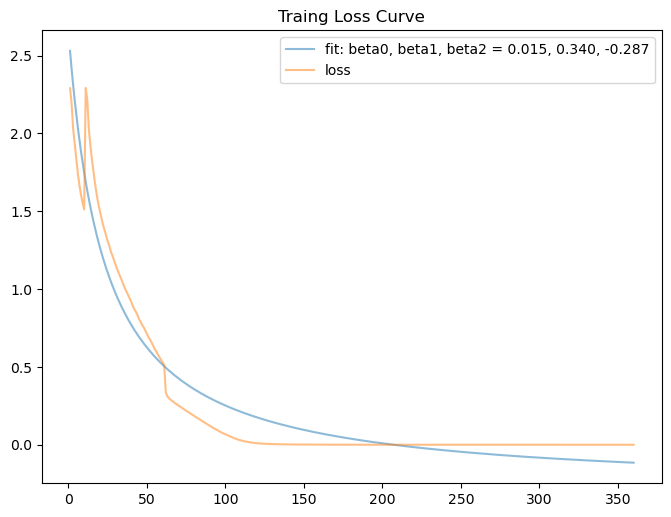

Model: Resnet18_P100 and beta_0, beta_1, beta_2:  [ 0.02002691  0.36572895 -0.22435743]


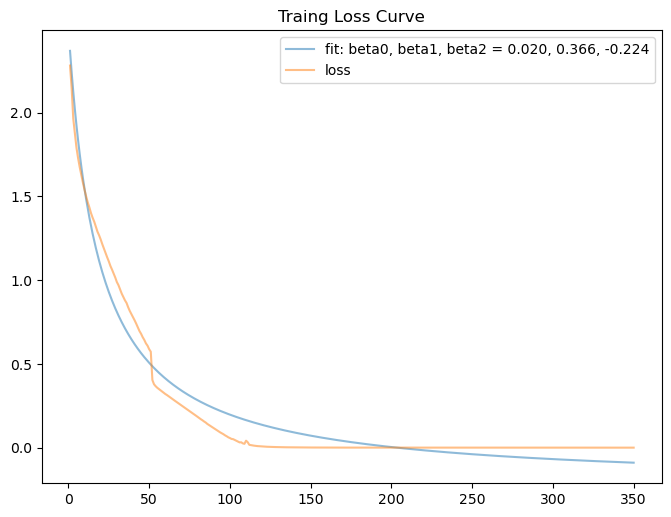

Model: Resnet18_V100 and beta_0, beta_1, beta_2:  [ 0.03913523  0.58109211 -0.1295579 ]


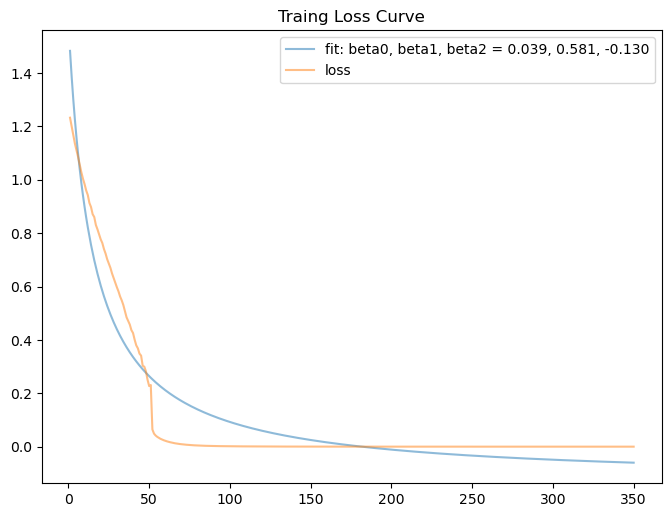

Model: Resnet20_T4 and beta_0, beta_1, beta_2:  [0.03794046 0.48863114 0.07818745]


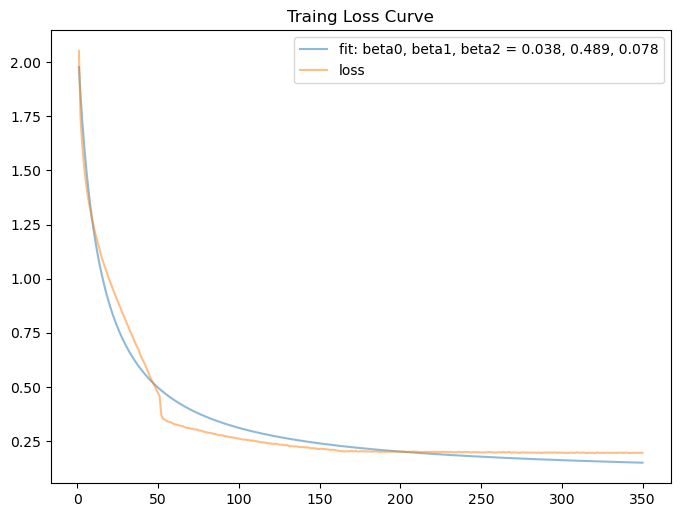

Model: Resnet20_P100 and beta_0, beta_1, beta_2:  [0.03857567 0.48074116 0.08130758]


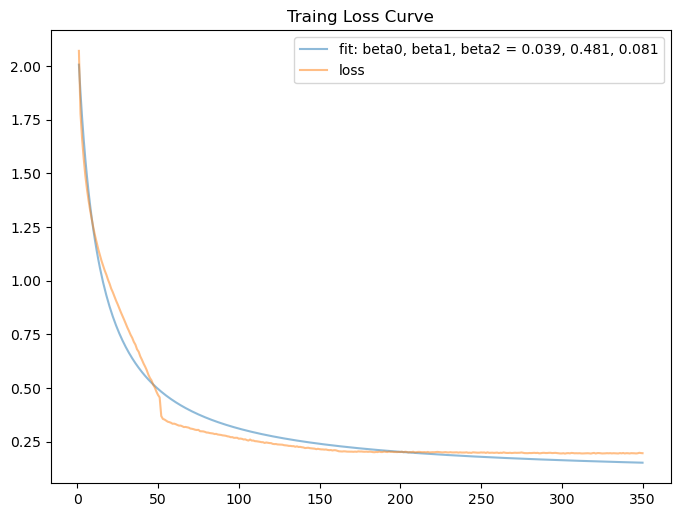

Model: Resnet20_V100 and beta_0, beta_1, beta_2:  [0.03549    0.49609278 0.09249381]


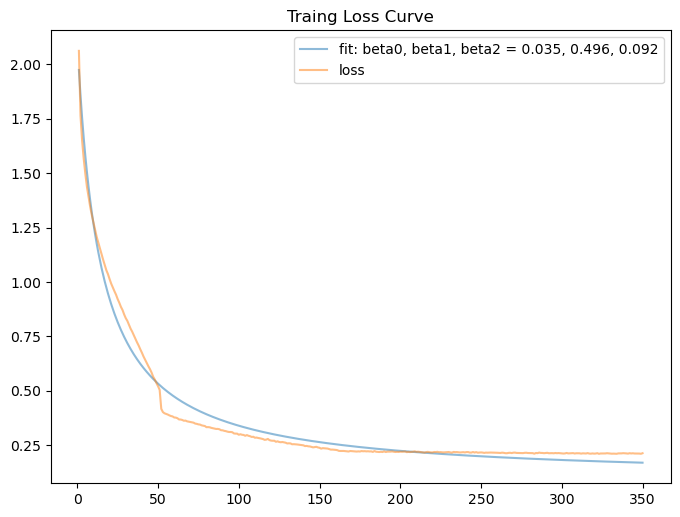

Model: Resnet32_T4 and beta_0, beta_1, beta_2:  [0.04439342 0.45859814 0.12606475]


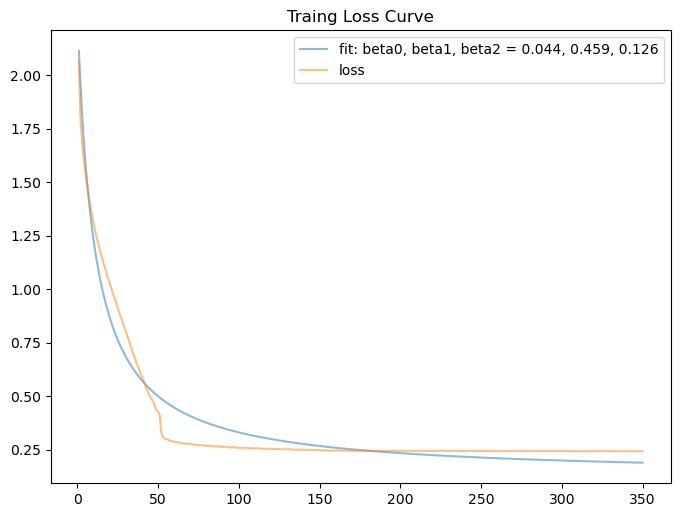

Model: Resnet32_P100 and beta_0, beta_1, beta_2:  [0.04485698 0.46264699 0.12619802]


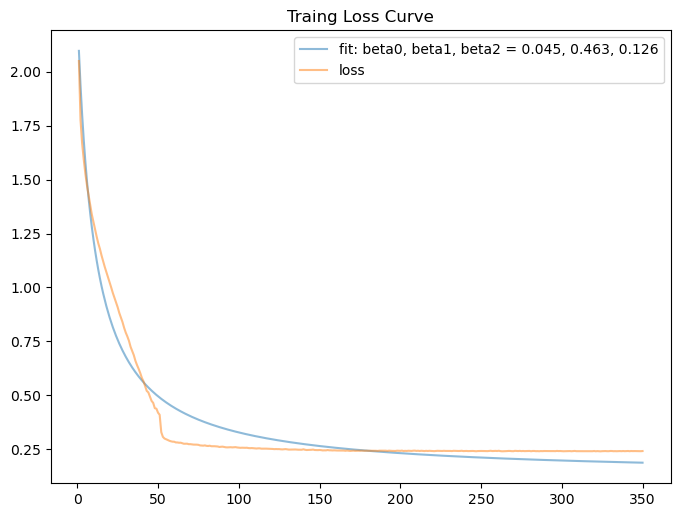

Model: Resnet32_V100 and beta_0, beta_1, beta_2:  [0.04589672 0.45811445 0.12813663]


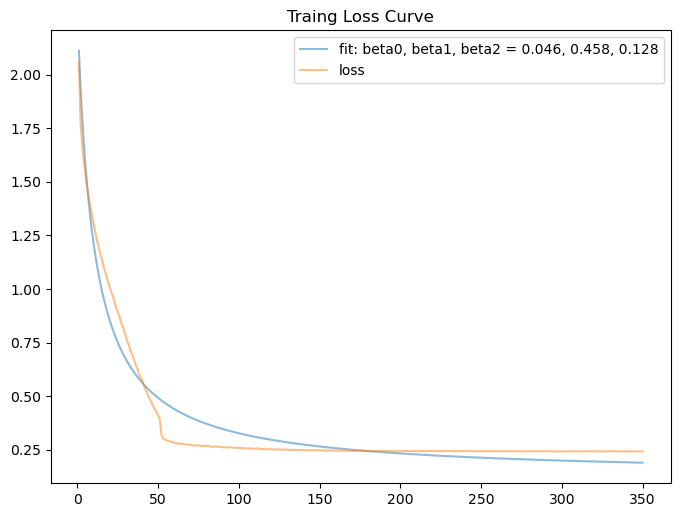

Model: Resnet44_T4 and beta_0, beta_1, beta_2:  [0.05141814 0.43554181 0.2109242 ]


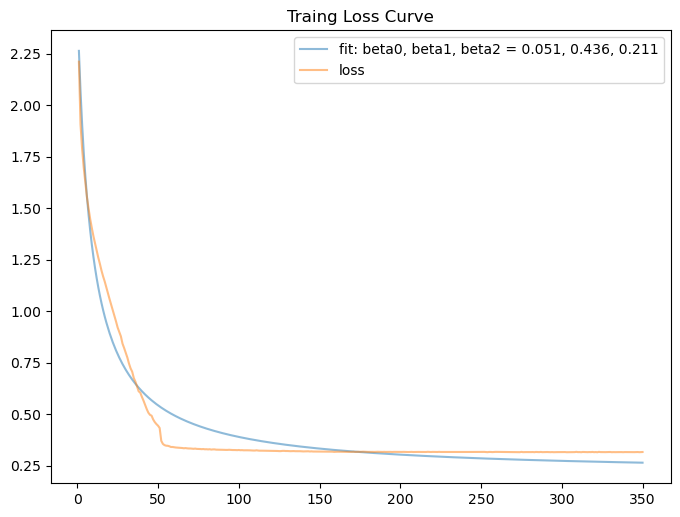

Model: Resnet44_P100 and beta_0, beta_1, beta_2:  [0.05198123 0.46074074 0.21429275]


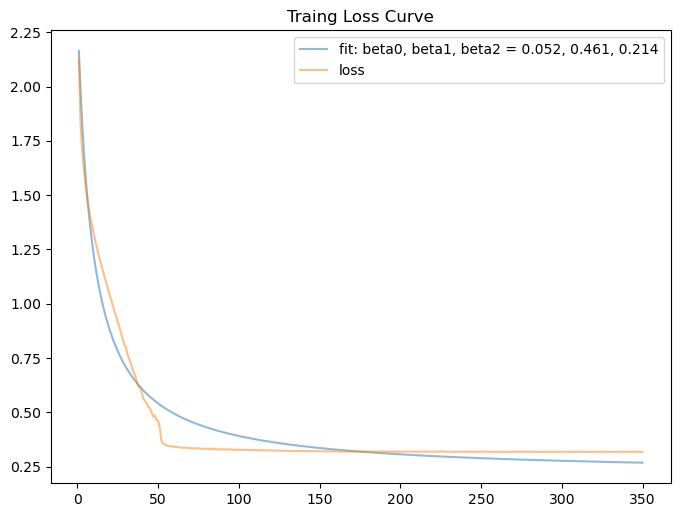

Model: Resnet44_V100 and beta_0, beta_1, beta_2:  [0.05828248 0.43648351 0.21838927]


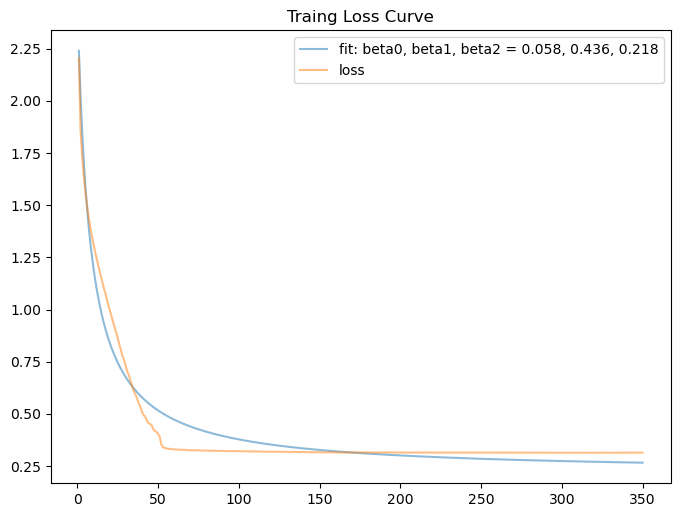

Model: Resnet56_T4 and beta_0, beta_1, beta_2:  [0.05728524 0.44416688 0.299743  ]


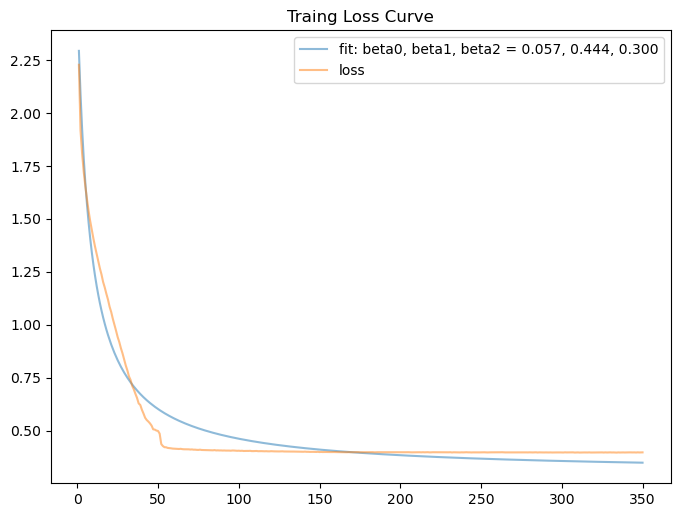

Model: Resnet56_P100 and beta_0, beta_1, beta_2:  [0.0554833  0.42197032 0.29573862]


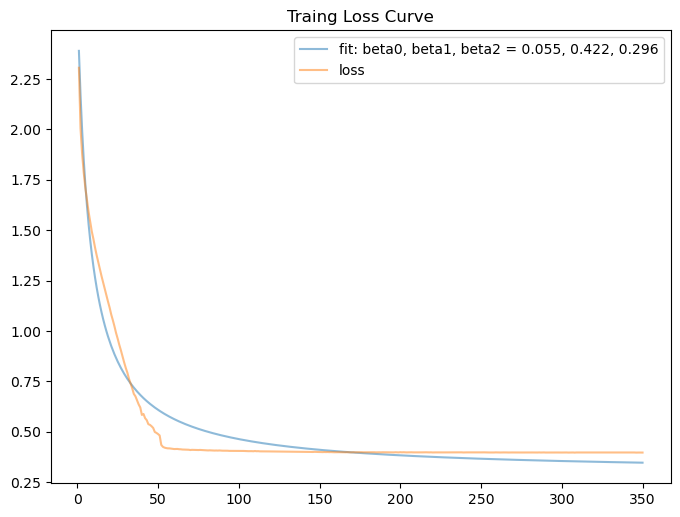

Model: Resnet56_V100 and beta_0, beta_1, beta_2:  [0.04741941 0.42875508 0.28681418]


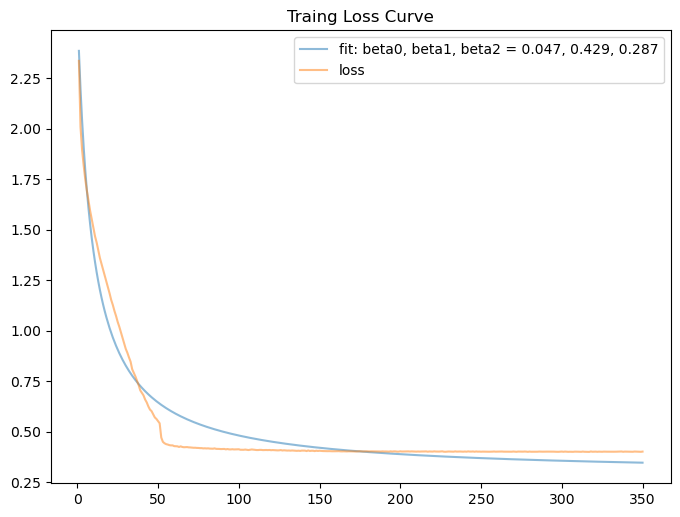

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

Resnet18_T4= pd.read_csv('Resnet/log_18_T4_sgd_v2.csv')
Resnet18_P100= pd.read_csv('Resnet/log_18_P100_sgd_v2.csv')
Resnet18_V100= pd.read_csv('Resnet/log_18_V100_sgd_v2.csv')

Resnet20_T4= pd.read_csv('Resnet/log_20_T4_sgd_v2.csv')
Resnet20_P100= pd.read_csv('Resnet/log_20_P100_sgd_v2.csv')
Resnet20_V100= pd.read_csv('Resnet/log_20_V100_sgd_v2.csv')

Resnet32_T4= pd.read_csv('Resnet/log_32_T4_sgd_v2.csv')
Resnet32_P100= pd.read_csv('Resnet/log_32_P100_sgd_v2.csv')
Resnet32_V100= pd.read_csv('Resnet/log_32_V100_sgd_v2.csv')

Resnet44_T4= pd.read_csv('Resnet/log_44_T4_sgd_v2.csv')
Resnet44_P100= pd.read_csv('Resnet/log_44_P100_sgd_v2.csv')
Resnet44_V100= pd.read_csv('Resnet/log_44_V100_sgd_v2.csv')

Resnet56_T4= pd.read_csv('Resnet/log_56_T4_sgd_v2.csv')
Resnet56_P100= pd.read_csv('Resnet/log_56_P100_sgd_v2.csv')
Resnet56_V100= pd.read_csv('Resnet/log_56_V100_sgd_v2.csv')

def tlfct(k, beta0, beta1, beta2):
    return 1./(beta0 * k + beta1) + beta2 

Columns = [Resnet18_T4,Resnet18_P100,Resnet18_V100,
          Resnet20_T4,Resnet20_P100,Resnet20_V100,
          Resnet32_T4,Resnet32_P100,Resnet32_V100,
          Resnet44_T4,Resnet44_P100,Resnet44_V100,
          Resnet56_T4,Resnet56_P100,Resnet56_V100]

Columns_name = ['Resnet18_T4','Resnet18_P100','Resnet18_V100',
          'Resnet20_T4','Resnet20_P100','Resnet20_V100',
          'Resnet32_T4','Resnet32_P100','Resnet32_V100',
          'Resnet44_T4','Resnet44_P100','Resnet44_V100',
          'Resnet56_T4','Resnet56_P100','Resnet56_V100']

for i in range(0,15):
    steps = np.array(list(range(1, len(Columns[i]['loss'])+1)))
    popt, pcov = curve_fit(tlfct, steps, np.array(Columns[i]['loss']),p0=[0.1, 0.5, 0.1])
    print("Model:", Columns_name[i], "and beta_0, beta_1, beta_2: ", popt)
    plot = tlfct(steps, popt[0], popt[1], popt[2])
    plt.figure(figsize=(8, 6), dpi=100) 
    plt.title("Traing Loss Curve")
    plt.plot(steps, plot, alpha=0.5, label='fit: beta0, beta1, beta2 = %.3f, %.3f, %.3f' % (popt[0], popt[1], popt[2]))
    plt.plot(steps, Columns[i]['loss'], alpha=0.5, label='loss')
    plt.legend()
    plt.show()

### 4.2

In [2]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_percentage_error, r2_score

T_4_b0 = []
T_4_b1 = []
T_4_b2 = []

P100_b0 = []
P100_b1 = []
P100_b2 = []

V100_b0 = []
V100_b1 = []
V100_b2 = []

T4_ = [0,3,6,9,12]
P100_ = [1,4,7,10,13]
V100_ = [2,5,8,11,14]


for i in T4_:
    steps = np.array(list(range(1, len(Columns[i]['loss'])+1)))
    popt, pcov = curve_fit(tlfct, steps, np.array(Columns[i]['loss']),p0=[0.1, 0.5, 0.1])
    T_4_b0.append(popt[0])
    T_4_b1.append(popt[1])
    T_4_b2.append(popt[2])
    
for i in P100_:
    steps = np.array(list(range(1, len(Columns[i]['loss'])+1)))
    popt, pcov = curve_fit(tlfct, steps, np.array(Columns[i]['loss']),p0=[0.1, 0.5, 0.1])
    P100_b0.append(popt[0])
    P100_b1.append(popt[1])
    P100_b2.append(popt[2])
    
for i in V100_:
    steps = np.array(list(range(1, len(Columns[i]['loss'])+1)))
    popt, pcov = curve_fit(tlfct, steps, np.array(Columns[i]['loss']),p0=[0.1, 0.5, 0.1])
    V100_b0.append(popt[0])
    V100_b1.append(popt[1])
    V100_b2.append(popt[2])    
    
model = linear_model.LinearRegression()
X_ = np.array([18,20,32,44,56]).reshape(-1, 1)
X_axis = np.arange(5,60,0.1)

Preicted Coef. for beta_0(including intercept): 
 0.01140577717168852 0.0008772971655874464
Preicted Coef. for beta_1(including intercept): 
 0.4029218070476654 0.0008952979671737682
Preicted Coef. for beta_2(including intercept): 
 -0.30504816283931113 0.011489201541408844
Preicted Coef. for Resnet 50 using T_4: 
 [0.05527064] [0.44768671] [0.26941191]


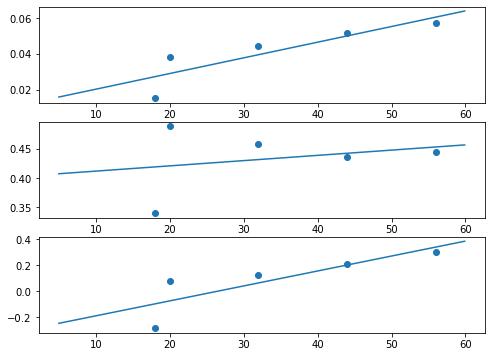

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,6))

model.fit(X_,T_4_b0)
print('Preicted Coef. for beta_0(including intercept): \n', model.intercept_, model.coef_[0])
ax1.scatter(X_,T_4_b0)
ax1.plot(X_axis,model.intercept_+model.coef_*X_axis)
T_4_pred_b_0 = model.intercept_+model.coef_*50

model.fit(X_,T_4_b1)
print('Preicted Coef. for beta_1(including intercept): \n', model.intercept_, model.coef_[0])
ax2.scatter(X_,T_4_b1)
ax2.plot(X_axis,model.intercept_+model.coef_*X_axis)
T_4_pred_b_1 = model.intercept_+model.coef_*50


model.fit(X_,T_4_b2)
print('Preicted Coef. for beta_2(including intercept): \n', model.intercept_, model.coef_[0])
ax3.scatter(X_,T_4_b2)
ax3.plot(X_axis,model.intercept_+model.coef_*X_axis)
T_4_pred_b_2 = model.intercept_+model.coef_*50


print('Preicted Coef. for Resnet 50 using T_4: \n',T_4_pred_b_0,T_4_pred_b_1,T_4_pred_b_2)

Preicted Coef. for beta_0(including intercept): 
 0.016350017478454167 0.0007598470240288849
Preicted Coef. for beta_1(including intercept): 
 0.42583071377087145 0.0003686740586450041
Preicted Coef. for beta_2(including intercept): 
 -0.2560165761787334 0.010430955482539025
Preicted Coef. for Resnet 50 using P100: 
 [0.05434237] [0.44426442] [0.2655312]


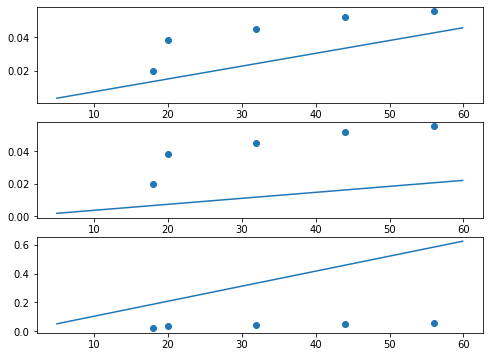

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,6))

model.fit(X_,P100_b0)
print('Preicted Coef. for beta_0(including intercept): \n', model.intercept_, model.coef_[0])
ax1.scatter(X_,P100_b0)
ax1.plot(X_axis,model.coef_*X_axis)
P100_pred_b_0 = model.intercept_+model.coef_*50

model.fit(X_,P100_b1)
print('Preicted Coef. for beta_1(including intercept): \n', model.intercept_, model.coef_[0])
ax2.scatter(X_,P100_b0)
ax2.plot(X_axis,model.coef_*X_axis)
P100_pred_b_1 = model.intercept_+model.coef_*50

model.fit(X_,P100_b2)
print('Preicted Coef. for beta_2(including intercept): \n', model.intercept_, model.coef_[0])
ax3.scatter(X_,P100_b0)
ax3.plot(X_axis,model.coef_*X_axis)
P100_pred_b_2 = model.intercept_+model.coef_*50


print('Preicted Coef. for Resnet 50 using P100: \n',P100_pred_b_0,P100_pred_b_1,P100_pred_b_2)

Preicted Coef. for beta_0(including intercept): 
 0.03180055301183754 0.0003954180558413217
Preicted Coef. for beta_1(including intercept): 
 0.5900045689274227 -0.003232264153458345
Preicted Coef. for beta_2(including intercept): 
 -0.17548374988888196 0.008668792599865065
Preicted Coef. for Resnet 50 using V100: 
 [0.05157146] [0.42839136] [0.25795588]


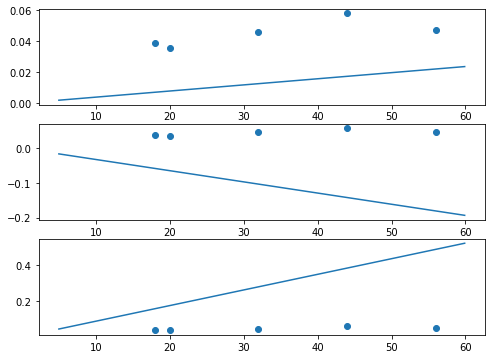

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,6))

model.fit(X_,V100_b0)
print('Preicted Coef. for beta_0(including intercept): \n', model.intercept_, model.coef_[0])
ax1.scatter(X_,V100_b0)
ax1.plot(X_axis,model.coef_*X_axis)
V100_pred_b_0 = model.intercept_+model.coef_*50

model.fit(X_,V100_b1)
print('Preicted Coef. for beta_1(including intercept): \n', model.intercept_, model.coef_[0])
ax2.scatter(X_,V100_b0)
ax2.plot(X_axis,model.coef_*X_axis)
V100_pred_b_1 = model.intercept_+model.coef_*50

model.fit(X_,V100_b2)
print('Preicted Coef. for beta_2(including intercept): \n', model.intercept_, model.coef_[0])
ax3.scatter(X_,V100_b0)
ax3.plot(X_axis,model.coef_*X_axis)
V100_pred_b_2 = model.intercept_+model.coef_*50

print('Preicted Coef. for Resnet 50 using V100: \n',V100_pred_b_0,V100_pred_b_1,V100_pred_b_2)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

Resnet50_T4= pd.read_csv('Resnet/log_50_T4_sgd_v2.csv')
Resnet50_P100= pd.read_csv('Resnet/log_50_P100_sgd_v2.csv')
Resnet50_V100= pd.read_csv('Resnet/log_50_V100_sgd_v2.csv')

def tlfct(k, beta0, beta1, beta2):
    return 1./(beta0 * k + beta1) + beta2 

#,Resnet50_P100['accuracy'],Resnet50_V100['accuracy']
Resnet50_T4_ = list(Resnet50_T4['accuracy'])
Resnet50_P100_ = list(Resnet50_P100['accuracy'])
Resnet50_V100_ = list(Resnet50_V100['accuracy'])

print("Reaching 92% accuracy of Resnet50:", Resnet50_T4_[-1],Resnet50_P100_[-1],Resnet50_V100_[-1])

Reaching 92% accuracy of Resnet50: 0.924799979 0.923699975 0.923340023


Model:Resnet50_T4 and beta_0, beta_1, beta_2:  [ 0.01687281  0.42343463 -0.25449288]
Model:Resnet50_T4 Absolute Percentage Error 1.4638730407765188


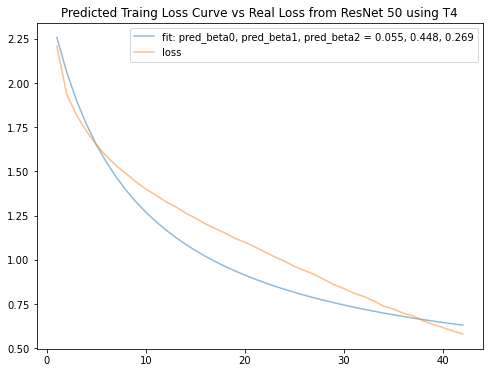

Model:Resnet50_P100 and beta_0, beta_1, beta_2:  [ 0.02171621  0.45531555 -0.11024269]
Model:Resnet50_P100 Absolute Percentage Error 1.6450882239254956


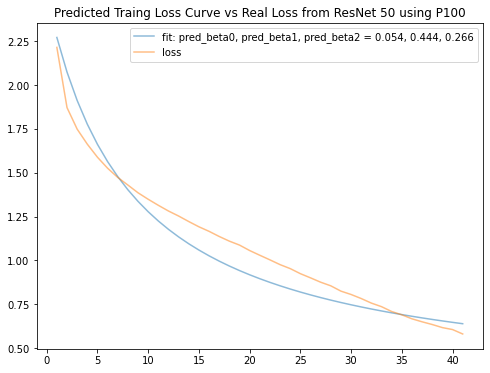

Model:Resnet50_V100 and beta_0, beta_1, beta_2:  [ 0.01793332  0.4132416  -0.29655604]
Model:Resnet50_V100 Absolute Percentage Error 1.2607441876754655


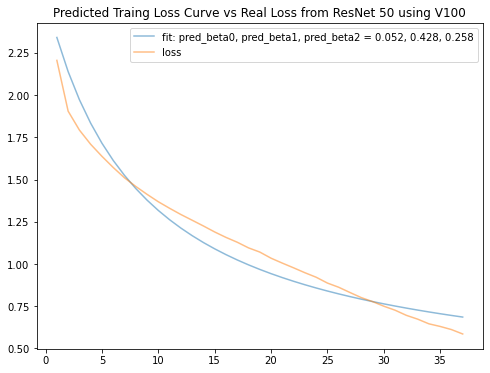

In [21]:
fig = plt.figure(figsize=(8,6)) 
steps = np.array(list(range(1, len(Resnet50_T4['loss'])+1)))
popt, pcov = curve_fit(tlfct, steps, np.array(Resnet50_T4['loss']),p0=[0.1, 0.5, 0.1])
plt.title("Predicted Traing Loss Curve vs Real Loss from ResNet 50 using T4")
plt.plot(steps, tlfct(steps, T_4_pred_b_0, T_4_pred_b_1, T_4_pred_b_2), alpha=0.5, label='fit: pred_beta0, pred_beta1, pred_beta2 = %.3f, %.3f, %.3f' % (T_4_pred_b_0, T_4_pred_b_1, T_4_pred_b_2))
print("Model:Resnet50_T4", "and beta_0, beta_1, beta_2: ", popt)
pred_T4 = [T_4_pred_b_0[0],T_4_pred_b_1[0],T_4_pred_b_2[0]]
print("Model:Resnet50_T4", "Absolute Percentage Error", mean_absolute_percentage_error(popt, pred_T4))
plot = tlfct(steps, popt[0], popt[1], popt[2])
plt.plot(steps, Resnet50_T4['loss'], alpha=0.5, label='loss')
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,6)) 
steps = np.array(list(range(1, len(Resnet50_P100['loss'])+1)))
popt, pcov = curve_fit(tlfct, steps, np.array(Resnet50_P100['loss']),p0=[0.1, 0.5, 0.1])
plt.title("Predicted Traing Loss Curve vs Real Loss from ResNet 50 using P100")
plt.plot(steps, tlfct(steps, P100_pred_b_0, P100_pred_b_1, P100_pred_b_2), alpha=0.5, label='fit: pred_beta0, pred_beta1, pred_beta2 = %.3f, %.3f, %.3f' % (P100_pred_b_0, P100_pred_b_1, P100_pred_b_2))
print("Model:Resnet50_P100", "and beta_0, beta_1, beta_2: ", popt)
pred_P100 = [P100_pred_b_0[0], P100_pred_b_1[0], P100_pred_b_2[0]]
print("Model:Resnet50_P100", "Absolute Percentage Error", mean_absolute_percentage_error(popt, pred_P100))
plot = tlfct(steps, popt[0], popt[1], popt[2])
plt.plot(steps, Resnet50_P100['loss'], alpha=0.5, label='loss')
plt.legend()
plt.show()
    



    
fig = plt.figure(figsize=(8,6)) 
steps = np.array(list(range(1, len(Resnet50_V100['loss'])+1)))
popt, pcov = curve_fit(tlfct, steps, np.array(Resnet50_V100['loss']),p0=[0.1, 0.5, 0.1])
plt.title("Predicted Traing Loss Curve vs Real Loss from ResNet 50 using V100")
plt.plot(steps, tlfct(steps, V100_pred_b_0, V100_pred_b_1, V100_pred_b_2), alpha=0.5, label='fit: pred_beta0, pred_beta1, pred_beta2 = %.3f, %.3f, %.3f' % (V100_pred_b_0, V100_pred_b_1, V100_pred_b_2))
print("Model:Resnet50_V100", "and beta_0, beta_1, beta_2: ", popt)
pred_V100 = [V100_pred_b_0[0], V100_pred_b_1[0], V100_pred_b_2[0]]
print("Model:Resnet50_V100", "Absolute Percentage Error", mean_absolute_percentage_error(popt, pred_V100))
plot = tlfct(steps, popt[0], popt[1], popt[2])
plt.plot(steps, Resnet50_V100['loss'], alpha=0.5, label='loss')
plt.legend()
plt.show()



 


As you may see from the three graphs above, our predicted traing loss curve using estimates from 5 different Resnet coeffients have done a fairly good job to predict the test accuracy (at the level of 92 \%) of real loss from Resnet using three different GPUs. In particular, V100 has best predicted outcomes related to two other GPUs. 


4.3 Using the predicted number of epochs for Resnet-50 along with the resource-speed model (use Equation
(4) in Peng et al. along with its coefficients from the paper) obtain the time to accuracy of Resnet-50 (to
reach 92\% accuracy) in two different setting (with 2 and 4 parameter servers respectively) as a function
of the number of workers. So you will be plotting two curves, one for 2 and one for 4 parameter server
case. Each curve will show how the time to achieve 92\% accuracy (on the y-axis) scales with number
of workers (on the x-axis).

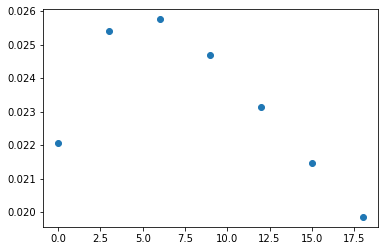

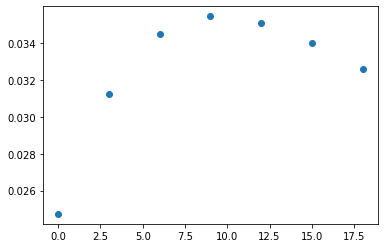

In [22]:
import numpy as np
import matplotlib.pyplot as plt

M = 128
p_1 = 2
p_2 = 4
theta_1 = 1.02
theta_2 = 2.78
theta_3 = 4.92
theta_4 = 0.00
theta_5 = 0.02

def tsf(M,w,p,theta_1,theta_2, theta_3,theta_4,theta_5):
    return 1./(theta_1 *(M/w)+theta_2+theta_3*(w/p)+theta_4*w+theta_5*p)

workers_2 = [tsf(M,4,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,6,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,8,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,10,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,12,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,14,p_1,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,16,p_1,theta_1,theta_2, theta_3,theta_4,theta_5)]

workers_4 = [tsf(M,4,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,6,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,8,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,10,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,12,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,14,p_2,theta_1,theta_2, theta_3,theta_4,theta_5),
tsf(M,16,p_2,theta_1,theta_2, theta_3,theta_4,theta_5)]

X_axis = np.arange(0,21,3)
plt.scatter(X_axis,workers_2)
plt.show()

plt.scatter(X_axis,workers_4)
plt.show()